In [1]:
!pip install graphviz
!pip install pydot

In [2]:
import tensorflow.keras.layers as layers
import tensorflow as tf

# U-Net 구현
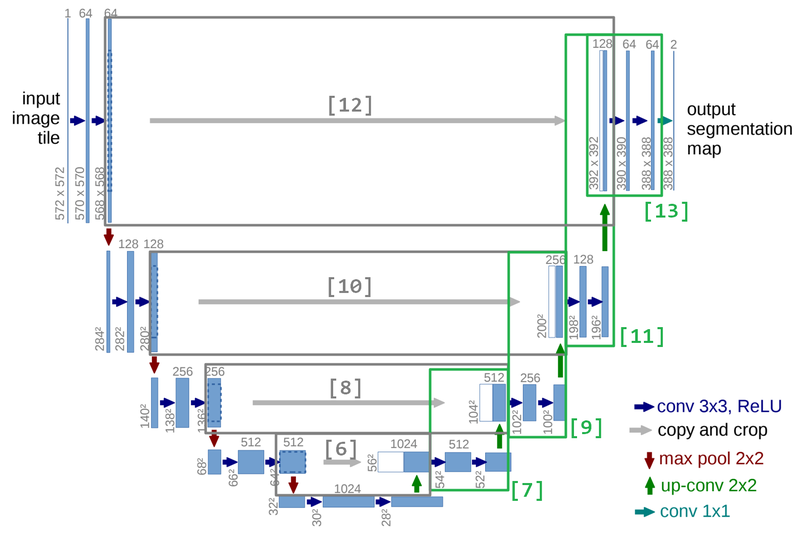

In [4]:
inputs = layers.Input(shape=(572, 572, 1))

# Contracting path 시작
# [1]
conv0 = layers.Conv2D(64, activation='relu', kernel_size=3)(inputs)
conv1 = layers.Conv2D(64, activation='relu', kernel_size=3)(conv0)  # Skip connection으로 Expanding path로 이어질 예정
conv2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv1)


# Q.위 이미지를 보고 [2]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv3 = layers.Conv2D(128, activation='relu', kernel_size=3)(conv2)
conv4 = layers.Conv2D(128, activation='relu', kernel_size=3)(conv3)
conv5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv4)


# Q.위 이미지를 보고 [3]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv6 = layers.Conv2D(256, activation='relu', kernel_size=3)(conv5)
conv7 = layers.Conv2D(256, activation='relu', kernel_size=3)(conv6)
conv8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv7)


# Q.위 이미지를 보고 [4]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv9 = layers.Conv2D(512, activation='relu', kernel_size=3)(conv8)
conv10 = layers.Conv2D(512, activation='relu', kernel_size=3)(conv9)
conv11 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv10)


# [5]
conv12 = layers.Conv2D(1024, activation='relu', kernel_size=3)(conv11)
conv13 = layers.Conv2D(1024, activation='relu', kernel_size=3)(conv12)

# Contracting path 끝


# Expanding path 시작 (Skip connection 잘 짜주기)
# [6]
trans01 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(conv13)
crop01 = layers.Cropping2D(cropping=(4, 4))(conv10)
concat01 = layers.concatenate([trans01, crop01], axis=-1)

# [7]
conv14 = layers.Conv2D(512, activation='relu', kernel_size=3)(concat01)
conv15 = layers.Conv2D(512, activation='relu', kernel_size=3)(conv14)
trans02 = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu')(conv15)

# [8]
crop02 = layers.Cropping2D(cropping=(16, 16))(conv7)
concat02 = layers.concatenate([trans02, crop02], axis=-1)


# Q.위 이미지를 보고 [9]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv16 = layers.Conv2D(256, activation='relu', kernel_size=3)(concat02)
conv17 = layers.Conv2D(256, activation='relu', kernel_size=3)(conv16)
trans03 = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu')(conv17)


# Q.위 이미지를 보고 [10]번 블럭을 구현해 봅시다. (cropping=(40, 40))
crop03 = layers.Cropping2D(cropping=(40, 40))(conv4)
concat03 = layers.concatenate([trans03, crop03], axis=-1)


# Q.위 이미지를 보고 [11]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv18 = layers.Conv2D(128, activation='relu', kernel_size=3)(concat03)
conv19 = layers.Conv2D(128, activation='relu', kernel_size=3)(conv18)
trans04 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu')(conv19)


# Q.위 이미지를 보고 [12]번 블럭을 구현해 봅시다. (cropping=(88, 88))
crop04 = layers.Cropping2D(cropping=(88, 88))(conv1)
concat04 = layers.concatenate([trans04, crop04], axis=-1)


# [13]
conv20 = layers.Conv2D(64, activation='relu', kernel_size=3)(concat04)
conv21 = layers.Conv2D(64, activation='relu', kernel_size=3)(conv20)
# Expanding path 끝

outputs = layers.Conv2D(2, kernel_size=1)(conv21) #1x1 convolution

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")

* channel 방향으로 붙여주겠다 : concat의 axis= -1

In [5]:
model.summary()

Model: "u-netmodel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 572, 572, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 570, 570, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 568, 568, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 284, 284, 64) 0           conv2d_1[0][0]                   
_________________________________________________________________________________________

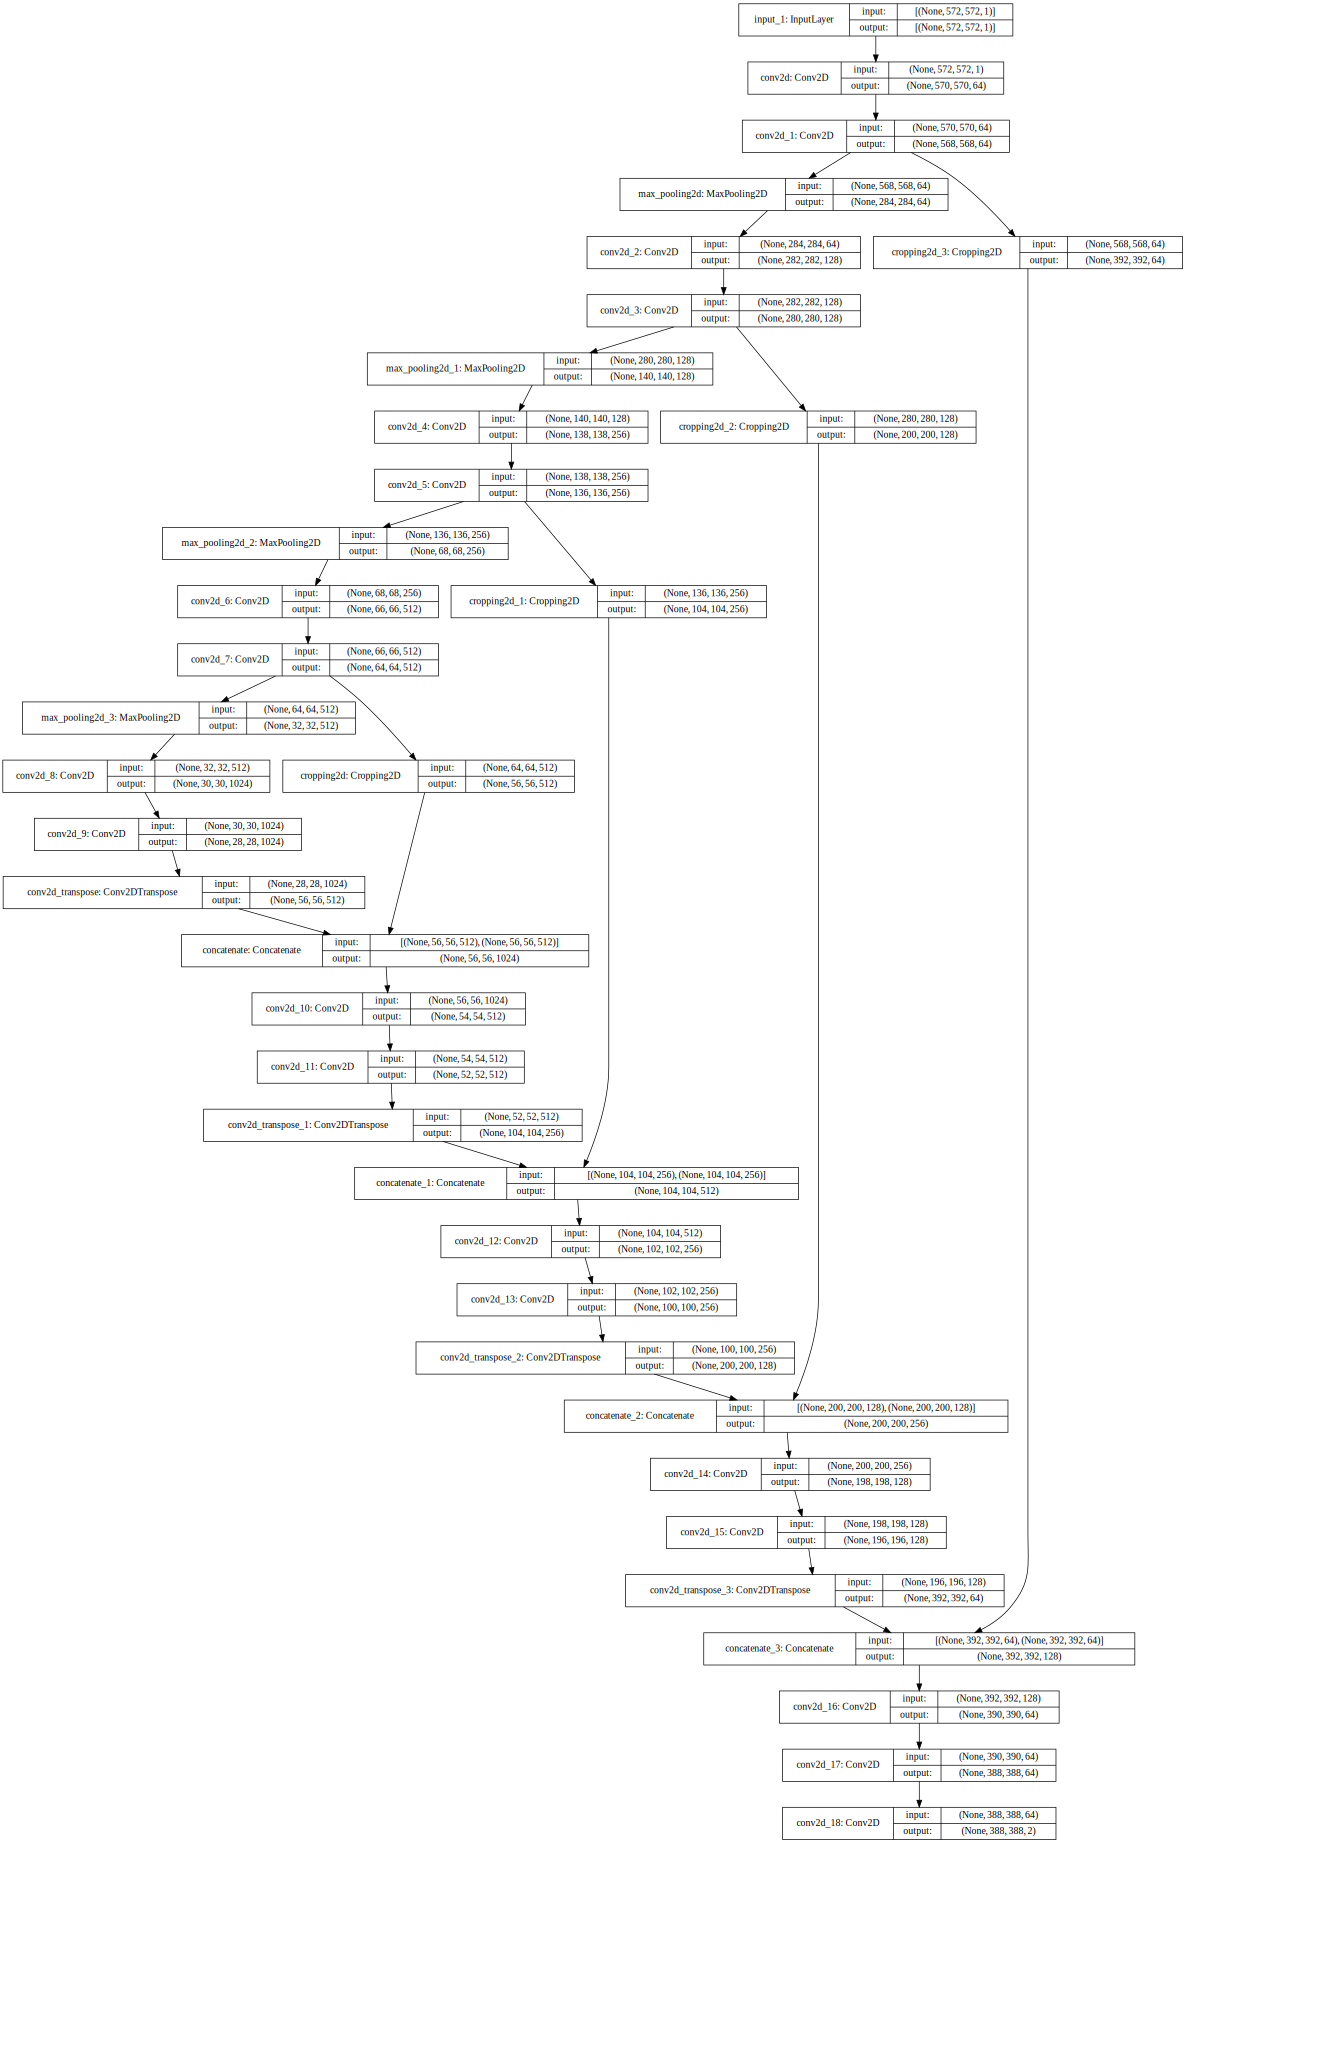

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot  

%matplotlib inline

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=80).create(prog='dot', format='svg'))  #dpi를 작게 하면 그래프가 커집니다.

# Transposed Convolution 의 코드

In [7]:
# 필요한 모듈 불러오기 
import numpy as np
import tensorflow as tf

In [9]:
# input data 
X = np.asarray([[1, 2], 
			  [3, 4]])

print(X.shape)
print(X)

(2, 2)
[[1 2]
 [3 4]]


In [10]:
# 모델에 맞게 reshaping 
X = X.reshape((1, 2, 2, 1))

In [11]:
print(X)
print(X.shape)

[[[[1]
   [2]]

  [[3]
   [4]]]]
(1, 2, 2, 1)


## 1) Build model

In [12]:
# 모델 만들기 
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2DTranspose(1, (1, 1), strides=(2, 2), input_shape=(2, 2, 1))) # Conv2DTranspos layer

In [13]:
# weights
weights = [np.asarray([[[[1]]]]), np.asarray([1])] # weight = 1, bias = 1

In [14]:
weights

[array([[[[1]]]]), array([1])]

In [15]:
model.set_weights(weights)

In [16]:
yhat = model.predict(X) 
yhat = yhat.reshape((4, 4)) # 결과를 확인하기 편하게 reshaping
print(yhat)

[[2. 1. 3. 1.]
 [1. 1. 1. 1.]
 [4. 1. 5. 1.]
 [1. 1. 1. 1.]]
